<a href="https://colab.research.google.com/github/EnjoyingMath/Nowadays-Studies/blob/main/TDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

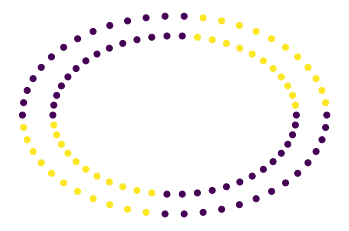

In [ ]:
X=make_circles(100)
y=[1 if (i[0]>0.1 and i[1]>0.1) or (i[0]<-0.1 and i[1]<-0.1) else 0 for i in X[0]]
plt.scatter(X[0][:,0],X[0][:,1],c=y)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
np.array(y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
!python -m pip install -U giotto-tda

In [ ]:
!pip install openml

In [ ]:
!pip install delayed

In [ ]:
from openml.datasets.functions import get_dataset
df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

,x,y,z,target
0,0.341007,0.318606,0.096725,human_arms_out9
1,0.329226,0.421601,0.056749,human_arms_out9
2,0.446869,0.648674,0.124090,human_arms_out9
3,0.314729,0.217860,0.070847,human_arms_out9
4,0.426678,0.919195,0.047609,human_arms_out9


In [ ]:
df['target'].map(lambda x:x[:-1]).value_counts()

dining_chair      4000
vase              4000
biplane           4000
human_arms_out    4000
Name: target, dtype: int64

In [ ]:
from gtda.plotting import plot_point_cloud,plot_diagram
plot=plot_point_cloud(df.query('target == "biplane0"')[["x", "y", "z"]].values)
plot

In [ ]:
from gtda.plotting import plot_point_cloud,plot_diagram
plot=plot_point_cloud(df.query('target == "human_arms_out0"')[["x", "y", "z"]].values)
plot

In [ ]:
type(plot)

plotly.graph_objs._figure.Figure

In [ ]:
plot.write_html('plot.html')

In [ ]:
import numpy as np

point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [ ]:
from gtda.homology import VietorisRipsPersistence

# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)

#Example Persistence Diagram
plot_diagram(persistence_diagrams[10])

In [ ]:
from gtda.diagrams import PersistenceEntropy
persistence_entropy = PersistenceEntropy(normalize=True)
# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)
X.shape

(40, 3)

In [ ]:
from gtda.diagrams import NumberOfPoints,Amplitude
from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [ ]:
from gtda.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("features", feature_union),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

In [ ]:
labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

In [ ]:
pipeline.fit(point_clouds,labels)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Pipeline(steps=[('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1, 2],
                                         n_jobs=6)),
                ('features',
                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                 PersistenceEntropy(normalize=True)),
                                                ('numberofpoints',
                                                 NumberOfPoints(n_jobs=-1)),
                                                ('amplitude-1',
                                                 Amplitude(metric='bottleneck',
                                                           n_jobs=-1)),
                                                ('amplitude-2',
                                                 Amplitude(metric='wasserstein',
                                                           n_jobs=-1)),
                                                ('amplitude-3',
                

In [ ]:
pipeline['model'].oob_score_

0.825